# Pix2Pix 실습

![Pix2Pix](./imgs/2_Pix2Pix.jpg)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt
from math import log10

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

![Facade](./imgs/2_Facade.png)

## Facades Dataloader

In [2]:
"""
MNIST 또는 CIFAR-10과 같이 torchvision 라이브러리에서 제공하지 않는 Dataset의 경우에는 직접 data.Dataset을 상속받아서 만들어야합니다.
이 때, __init__, __getitem__, __len__은 항상 새로 정의해줘야 합니다.
"""
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, direction):
        super(DatasetFromFolder, self).__init__()
        self.direction = direction
        self.a_path = os.path.join(image_dir, "a") # a는 건물 사진
        self.b_path = os.path.join(image_dir, "b") # b는 Segmentation Mask
        self.image_filenames = [x for x in os.listdir(self.a_path)] # a 폴더에 있는 파일 목록
        self.transform = T.Compose([T.Resize((256, 256)),
                                    T.ToTensor(), # Tensor로 바꿔주는 함수를 사용합니다
                                    T.Normalize(mean=(0.5, 0.5, 0.5), 
                                                std=(0.5, 0.5, 0.5))])

    # getitem 함수는 index에 맞는 data를 반환하는 역할을 합니다.
    def __getitem__(self, index):
        # a와 b 폴더에서 각각 건물 사진과 Segmentation Mask를 Load합니다.
        a = Image.open(os.path.join(self.a_path, self.image_filenames[index])).convert('RGB')
        b = Image.open(os.path.join(self.b_path, self.image_filenames[index])).convert('RGB')
        
        # a(건물사진)와 b(Segmentation Mask) 이미지를 각각 Resize를 하고, Tensor로 바꿔줍니다.
        a = self.transform(a)
        b = self.transform(b)

        if self.direction == "a2b":
            return a, b
        else:
            return b, a

    # len 함수는 Dataset 전체 개수를 반환합니다.
    def __len__(self):
        return len(self.image_filenames)

In [3]:
train_set = DatasetFromFolder("./data/facades/train/", "b2a")
test_set = DatasetFromFolder("./data/facades/test/", "b2a")

# Training Set과 Test Set을 각각 DataLoader에 넣습니다.
trainDataLoader = DataLoader(dataset=train_set, num_workers=4, batch_size=1, shuffle=True)
testDataLoader = DataLoader(dataset=test_set, num_workers=4, batch_size=1, shuffle=False)

In [4]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def show_images(real_a, real_b, fake_b):
    plt.figure(figsize=(30,90))
    plt.subplot(131)
    plt.imshow(real_a.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(132)
    plt.imshow(real_b.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(133)
    plt.imshow(fake_b.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

## Generator, Discriminator

### Conditional GAN
![Pix2Pix CGAN](./imgs/2_Pix2Pix_cgan.jpg)

### Patch GAN
![Pix2Pix Patch GAN](./imgs/2_Pix2Pix_patchgan.png)

## U-Net

![U-Net](./imgs/2_U_Net.png)

In [5]:
'''
코드 단순화를 위한 함수들을 정의해 줍니다.
'''

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 convolution block 생성을 위한 함수입니다.
    Conv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    layers = []
    
    # Conv.
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass
                
    return nn.Sequential(*layers)
  
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 deconvolution block 생성을 위한 함수입니다.
    Deconv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    
    layers = []
    
    # Deconv.
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass
                
    return nn.Sequential(*layers)

In [6]:
class Generator(nn.Module):
    # initializers
    def __init__(self):
        super(Generator, self).__init__()
        # Unet encoder
        self.conv1 = conv(3, 64, 4, bn=False, activation='lrelu') # (B, 64, 128, 128)
        self.conv2 = conv(64, 128, 4, activation='lrelu') # (B, 128, 64, 64)
        self.conv3 = conv(128, 256, 4, activation='lrelu') # (B, 256, 32, 32)
        self.conv4 = conv(256, 512, 4, activation='lrelu') # (B, 512, 16, 16)
        self.conv5 = conv(512, 512, 4, activation='lrelu') # (B, 512, 8, 8)
        self.conv6 = conv(512, 512, 4, activation='lrelu') # (B, 512, 4, 4)
        self.conv7 = conv(512, 512, 4, activation='lrelu') # (B, 512, 2, 2)
        self.conv8 = conv(512, 512, 4, bn=False, activation='relu') # (B, 512, 1, 1)

        # Unet decoder
        self.deconv1 = deconv(512, 512, 4, activation='relu') # (B, 512, 2, 2)
        self.deconv2 = deconv(1024, 512, 4, activation='relu') # (B, 512, 4, 4)
        self.deconv3 = deconv(1024, 512, 4, activation='relu') # (B, 512, 8, 8) # Hint : U-Net에서는 Encoder에서 넘어온 Feature를 Concat합니다! (Channel이 2배)
        self.deconv4 = deconv(1024, 512, 4, activation='relu') # (B, 512, 16, 16)
        self.deconv5 = deconv(1024, 256, 4, activation='relu') # (B, 256, 32, 32)
        self.deconv6 = deconv(512, 128, 4, activation='relu') # (B, 128, 64, 64)
        self.deconv7 = deconv(256, 64, 4, activation='relu') # (B, 64, 128, 128)
        self.deconv8 = deconv(128, 3, 4, activation='tanh') # (B, 3, 256, 256)

    # forward method
    def forward(self, input):
        # Unet encoder
        e1 = self.conv1(input)
        e2 = self.conv2(e1)
        e3 = self.conv3(e2)
        e4 = self.conv4(e3)
        e5 = self.conv5(e4)
        e6 = self.conv6(e5)
        e7 = self.conv7(e6)
        e8 = self.conv8(e7)
                              
        # Unet decoder
        d1 = F.dropout(self.deconv1(e8), 0.5, training=True)
        d2 = F.dropout(self.deconv2(torch.cat([d1, e7], 1)), 0.5, training=True)
        d3 = F.dropout(self.deconv3(torch.cat([d2, e6], 1)), 0.5, training=True)
        d4 = self.deconv4(torch.cat([d3, e5], 1))
        d5 = self.deconv5(torch.cat([d4, e4], 1))
        d6 = self.deconv6(torch.cat([d5, e3], 1))
        d7 = self.deconv7(torch.cat([d6, e2], 1))
        output = self.deconv8(torch.cat([d7, e1], 1))
        
        return output

In [7]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = conv(6, 64, 4, bn=False, activation='lrelu')
        self.conv2 = conv(64, 128, 4, activation='lrelu')
        self.conv3 = conv(128, 256, 4, activation='lrelu')
        self.conv4 = conv(256, 512, 4, 1, 1, activation='lrelu')
        self.conv5 = conv(512, 1, 4, 1, 1, activation='none')

    # forward method
    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)

        return out

In [8]:
G = Generator().cuda()
D = Discriminator().cuda()

## Training Pix2Pix

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Step[200/400], d_loss: 1.3852, g_loss: 5.9932


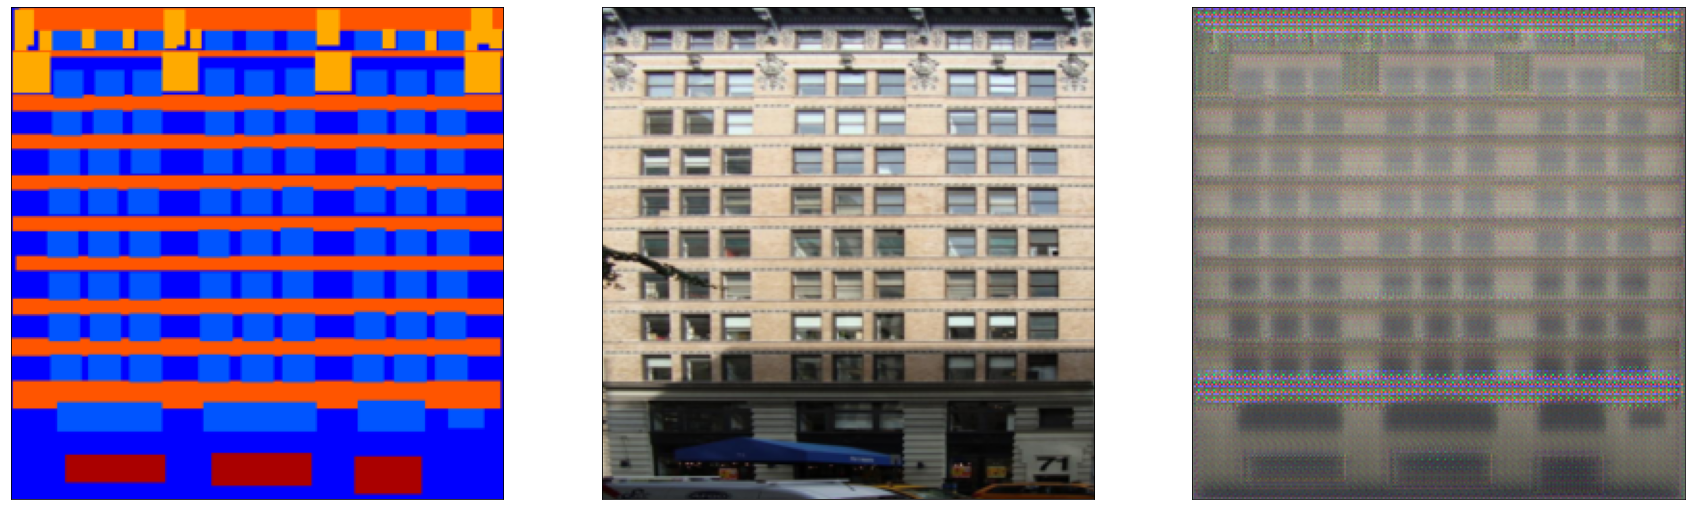

Epoch [1/100], Step[400/400], d_loss: 1.2788, g_loss: 5.9043


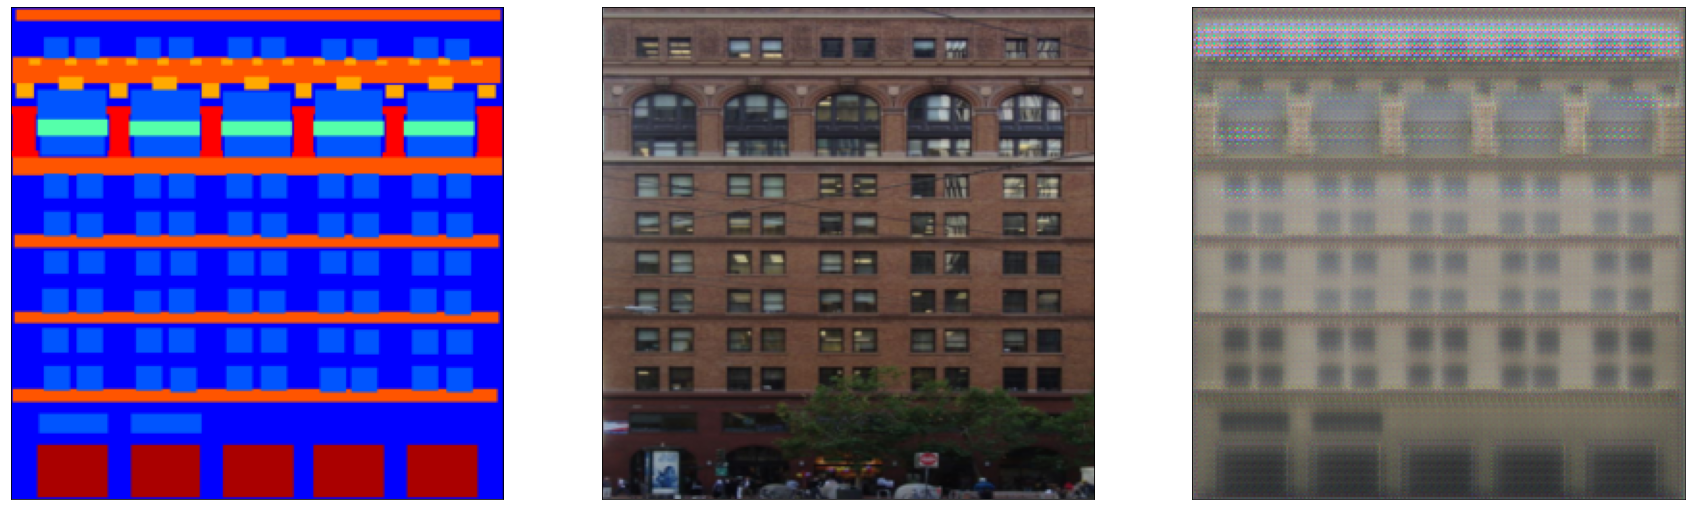

Epoch [2/100], Step[200/400], d_loss: 1.1806, g_loss: 5.3321


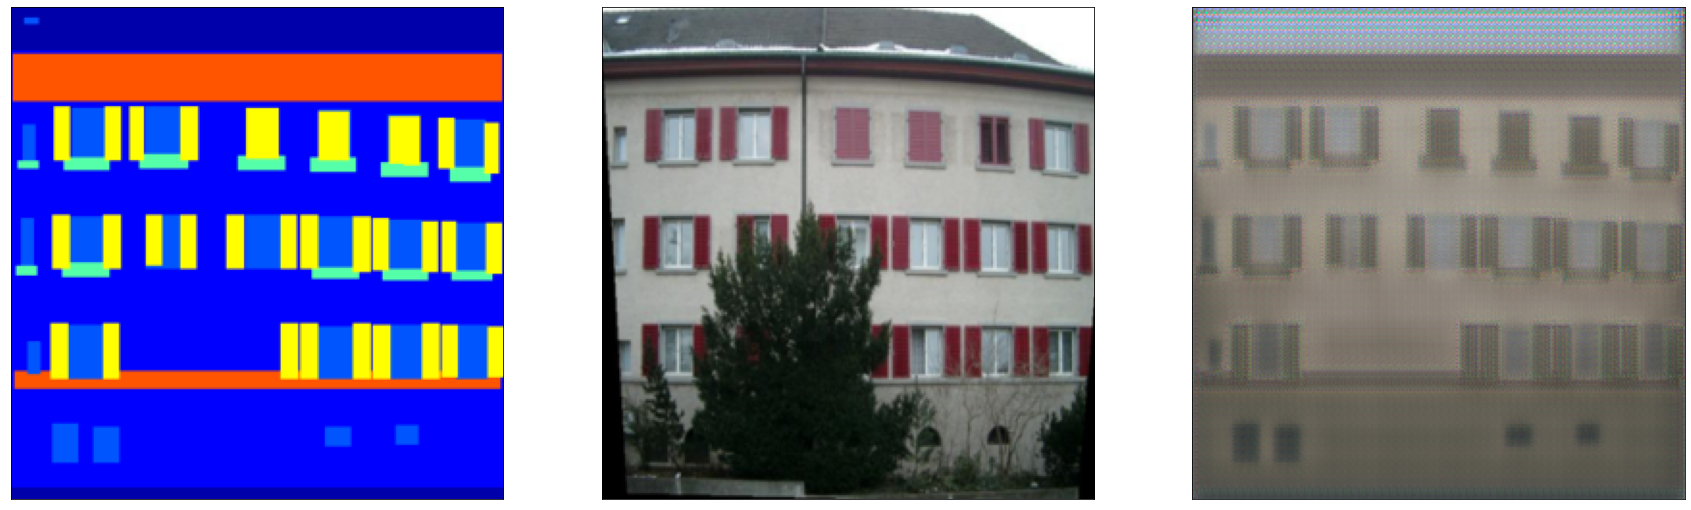

KeyboardInterrupt: 

In [9]:
criterionL1 = nn.L1Loss().cuda()
criterionMSE = nn.MSELoss().cuda()

# setup optimizer
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training
for epoch in range(1, 100):
    for i, (real_a, real_b) in enumerate(trainDataLoader, 1):
        # forward
        real_a, real_b = real_a.cuda(), real_b.cuda()
        real_label = torch.ones(1).cuda()
        fake_label = torch.zeros(1).cuda()
        
        fake_b = G(real_a)
        
        #============= Train the discriminator =============#
        # train with fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = D.forward(fake_ab.detach())
        loss_d_fake = criterionMSE(pred_fake, fake_label)

        # train with real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = D.forward(real_ab)
        loss_d_real = criterionMSE(pred_real, real_label)
        
        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5
        
        # Backprop + Optimize
        D.zero_grad()
        loss_d.backward()
        d_optimizer.step()

        #=============== Train the generator ===============#
        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = D.forward(fake_ab)
        loss_g_gan = criterionMSE(pred_fake, real_label)

        # Second, G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * 10
        
        loss_g = loss_g_gan + loss_g_l1
        
        # Backprop + Optimize
        G.zero_grad()
        D.zero_grad()
        loss_g.backward()
        g_optimizer.step()
        
        if i % 200 == 0:
            print('======================================================================================================')
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f'
                  % (epoch, 100, i, len(trainDataLoader), loss_d.item(), loss_g.item()))
            print('======================================================================================================')
            show_images(denorm(real_a.squeeze()), denorm(real_b.squeeze()), denorm(fake_b.squeeze()))